<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/MARCA-Color.jpg" title="Title text" width="50%" height="50%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales II-2018 </h1>

<H3 align='center'> Tarea 3 - Redes Recurrentes y Autoencoders </H3>
<hr style="height:2px;border:none"/>



**Temas**  
* Diseño e implementación de Redes Neuronales Recurrentes (RNN).
* Regularización en Redes Recurrentes.
* Autoencoders tradicionales y sus aplicaciones

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 21 de Diciembre (sin posibilidad de extensiones)
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<margarita.bugueno.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<cvalle@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF395-II-2018] 

<hr style="height:2px;border:none"/>

La tarea se divide en dos secciones:

[1.](#primero) RNN sobre texto    
[2.](#segundo) Autoencoder en MNIST  


### **Nota Importante:**  
Para esta actividad **si es que no se cuenta con GPU** se recomienda utilizar el entorno virtual de __[Colaboratory - Google](https://colab.research.google.com/)__* . Así, podrá programar en la nube con recursos elevados y luego descargar el Jupyter Notebook y entregarlo en modo Informe. 


<a id="primero"></a>
## 1. RNN sobre texto

Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto, proporcionadas por GMB (*Groningen Meaning Bank*), para reconocimiento de entidades y tagger. En específico, trabajaremos con el dataset proprocionado a través de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, que está compuesto por más de un millón de palabras, a fin de realizar predicciones sobre distintas tareas del tipo *many to many* y *many to one*.

<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />




##Carga Librerias y Def Funciones


In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from keras.layers import Bidirectional
from keras.preprocessing import sequence
from keras.utils import to_categorical
from collections import Counter

def print_f1_score():
  #from_categorical
  Y_test=np.argmax(y_test,axis=2)
  Y_test_predicted=np.argmax(model.predict(X_test,verbose=0),axis=2)
  #quitar padding
  Y_test_predicted=Y_test_predicted[Y_test!=0]
  Y_test=Y_test[Y_test!=0]
  #Convertir en arreglo unidimensional
  val_predict = Y_test_predicted.flatten()
  val_targ = np.asarray(Y_test).flatten()
  #calcular f1 score:
  result = f1_score(val_targ, val_predict,average='weighted')
  print("F1 score on test: ", result)
  return result

epochs=25;


##Descarga Dataset
Descargue los datos de la página de Kaggle y cárguelos mediante *pandas*.
```python
import numpy as np
import pandas as pd
df_ner = pd.read_csv("./entity-annotated-corpus/ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)
```


In [8]:
#montar drive para guardar y acceder a archivos
from google.colab import drive
drive.mount('/content/drive')
#Este queda montado en /drive/My Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#instalación de kaggle y configuración de autentificación para descarga de dataset 
!pip install -U -q kaggle #instalación paquete kaggle
!mkdir -p ~/.kaggle #Se debe colocar en esta carpeta la "llave"
!cd drive && cd 'My Drive' && cp kaggle.json ~/.kaggle/ 

In [10]:
#descarga del dataset
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus
print('\n Contenido:')
!ls #visualizar que se descargo

entity-annotated-corpus.zip: Skipping, found more recently modified local copy (use --force to force download)

 Contenido:
drive  entity-annotated-corpus	entity-annotated-corpus.zip  sample_data


In [11]:
#descomprimir
import zipfile
with zipfile.ZipFile('entity-annotated-corpus.zip', 'r') as zip_ref:
    zip_ref.extractall('entity-annotated-corpus')
!cd entity-annotated-corpus && ls

ner.csv  ner_dataset.csv


In [12]:
import numpy as np
import pandas as pd
df_ner = pd.read_csv("./entity-annotated-corpus/ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [13]:
df_ner.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050794 entries, 0 to 1050794
Data columns (total 25 columns):
Unnamed: 0         1050794 non-null int64
lemma              1050794 non-null object
next-lemma         1050794 non-null object
next-next-lemma    1050794 non-null object
next-next-pos      1050794 non-null object
next-next-shape    1050794 non-null object
next-next-word     1050794 non-null object
next-pos           1050794 non-null object
next-shape         1050794 non-null object
next-word          1050794 non-null object
pos                1050794 non-null object
prev-iob           1050794 non-null object
prev-lemma         1050794 non-null object
prev-pos           1050794 non-null object
prev-prev-iob      1050794 non-null object
prev-prev-lemma    1050794 non-null object
prev-prev-pos      1050794 non-null object
prev-prev-shape    1050794 non-null object
prev-prev-word     1050794 non-null object
prev-shape         1050794 non-null object
prev-word          1050794 n

In [14]:
df_ner.drop(['Unnamed: 0'],axis=1)
df_ner.head()


,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [15]:
#Se observan algunos tags de palabras para entender su significado.
#Se quitan los O ya la mayoria corresponden a estos.
df_ner[df_ner.tag!='O'][['tag','word']]

,tag,word
6,B-geo,London
12,B-geo,Iraq
18,B-gpe,British
42,B-per,Bush
65,B-geo,Hyde
66,I-geo,Park
94,B-geo,Britain
97,B-org,Labor
98,I-org,Party
102,B-gpe,English


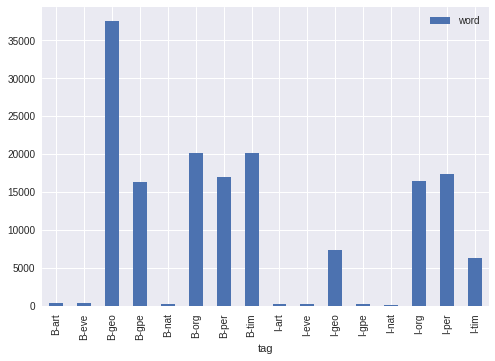

In [16]:
#Ver la distribución de los iob-tag.
df_ner[df_ner.tag!='O'][['tag','word']].groupby('tag').count().plot(kind='bar');

In [17]:
#Ahora se observan los menos frecuentes.
df_ner[df_ner.tag!='O'][df_ner.tag!='B-geo'][df_ner.tag!='B-gpe'][df_ner.tag!='B-org'][df_ner.tag!='B-per'][df_ner.tag!='B-tim'][df_ner.tag!='I-geo'][df_ner.tag!='I-org'][df_ner.tag!='I-per'][df_ner.tag!='I-tim'][['tag','word']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,tag,word
263,B-art,Nuclear
264,I-art,Non-Proliferation
1225,I-gpe,States
1264,I-gpe,Korea
2713,I-gpe,Binh
2723,B-nat,H5N1
2932,I-gpe,Ababa
3466,I-gpe,City
3769,B-art,Saltillo
3810,B-art,Pentastar


In [18]:
#Se observan algunos pos de palabras para entender su significado.
df_ner[['pos','word']]


,pos,word
0,NNS,Thousands
1,IN,of
2,NNS,demonstrators
3,VBP,have
4,VBN,marched
5,IN,through
6,NNP,London
7,TO,to
8,VB,protest
9,DT,the


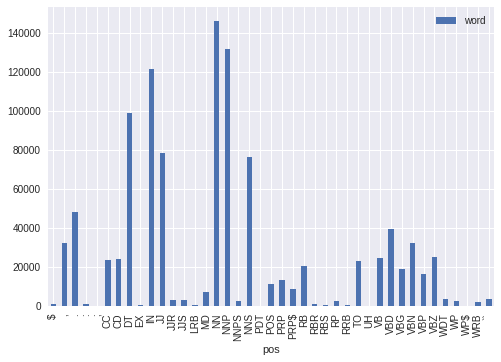

In [19]:
df_ner[['pos','word']].groupby('pos').count().plot(kind='bar');

Lo siguiente se obtiene de la descripción entregada en la información del Dataset de kaggle.

>**lemma:** Lemma of a token in sentence. <br>
**next-lemma:** Lemma of next token in sentence.<br>
**next-next-lemma:** Lemma of token at +2nd position to the current token in sentence.<br>
**next-next-pos:** POS tag of token at +2nd position to the current token in sentence.<br>
**next-next-shape:** Shape of token at +2nd position to the current token in sentence.<br>
**next-next-word:** Token at +2nd position to the current token in sentence.<br>
**next-pos:** POS tag of the next(+1 position) token.<br>
**next-shape:** Shape of the next(+1 position) token.<br>
**next-word:** Next(+1 position) token.<br>
**pos:** POS tag of current token.<br>
**prev-iob:** IOB annotation of previous token.<br>
**prev-lemma:** Lemma of previous token.<br>
**prev-pos:** POS tag for previous token.<br>
**prev-prev-iob:** IOB annotation of token at -2nd position to the current token in sentence.<br>
**prev-prev-lemma:** Lemma of token at -2nd position to the current token in sentence.<br>
**prev-prev-pos:** POS tag of token at -2nd position to the current token in sentence.<br>
**prev-prev-shape:** Shape of token at -2nd position to the current token in sentence.<br>
**prev-prev-word:** Token at -2nd position to the current token in sentence.<br>
**prev-shape:** Shape of previous(-1 position to current token) token.<br>
**prev-word:** Previous word(-1 position to current token).<br>
**sentence_idx:** Sentence Index(Tokens having same index belongs to same sentence).<br>
**shape:** Shape of the token in sentence.<br>
**word:** Often termed as Token.<br>
**tag:** IOB annotation of current token.<br>

De esto podemos ver que el dataset consta de una serie de sentencias (referenciado con sentence_id), con la palabra de la posición actual, su version lemmatizada y las vecinas, junto a información de POS, IOB y shape de la palabra actual y sus vecinas. De estos no queda muy claro cual es el significado de IOB y POS.
> **IOB:**  Significa Inside-Outside-Beggining, y entrega información del contexto de las palabras, en particular ayuda a identificar nombres de personas, empresas, etc; dando información adicional de cada chunck . la siguiente imagen ejemplifica su funcionamiento. 
![alt text](https://www.researchgate.net/profile/Robert_Greinacher/publication/319103317/figure/fig9/AS:631667559526419@1527612690132/A-named-entity-tagged-example-sentence-using-the-beginning-inside-outside-notation.png)
>>Subclasificaciones:<br>
art: Artefacto, objeto, marca, cosa.<br>
eve: Evento<br>
nat: Naturaleza<br>
geo: Geologico, lugar, <br>
gpe: Pertenencia geologica?<br>
org: Organización<br>
per: Persona<br>
tim: Tiempo<br>


>**POS:** Significa Part of speech.  nouns, pronouns, adjectives, verbs, adverbs, prepositions, conjunctions and interjections. En la siguiente tabla se espefica su significado.

<table class="border">
<tbody>
<tr>
<td><span class="smallcaps">Tag </span></td>
<td><span class="smallcaps">Description </span></td>
<td class="smallcaps">Example</td>
</tr>
<tr>
<td><span class="postag">CC </span></td>
<td>conjunction, coordinating</td>
<td><em>and, or, but</em></td>
</tr>
<tr>
<td><span class="postag">CD </span></td>
<td>cardinal number</td>
<td><em>five, three, 13%</em></td>
</tr>
<tr>
<td><span class="postag">DT </span></td>
<td>determiner</td>
<td><em>the, a, these <br></em></td>
</tr>
<tr>
<td><span class="postag">EX </span></td>
<td>existential there</td>
<td><em><span style="text-decoration: underline;">there</span> were six boys <br></em></td>
</tr>
<tr>
<td><span class="postag">FW </span></td>
<td>foreign word</td>
<td><em>mais <br></em></td>
</tr>
<tr>
<td><span class="postag">IN </span></td>
<td>conjunction, subordinating or preposition</td>
<td><em>of, on, before, unless <br></em></td>
</tr>
<tr>
<td><span class="postag">JJ </span></td>
<td>adjective</td>
<td><em>nice, easy </em></td>
</tr>
<tr>
<td><span class="postag">JJR </span></td>
<td>adjective, comparative</td>
<td><em>nicer, easier</em></td>
</tr>
<tr>
<td><span class="postag">JJS </span></td>
<td>adjective, superlative</td>
<td><em>nicest, easiest <br></em></td>
</tr>
<tr>
<td><span class="postag">LS </span></td>
<td>list item marker</td>
<td><em>&nbsp;</em></td>
</tr>
<tr>
<td><span class="postag">MD </span></td>
<td>verb, modal auxillary</td>
<td><em>may, should <br></em></td>
</tr>
<tr>
<td><span class="postag">NN </span></td>
<td>noun, singular or mass</td>
<td><em>tiger, chair, laughter <br></em></td>
</tr>
<tr>
<td><span class="postag">NNS </span></td>
<td>noun, plural</td>
<td><em>tigers, chairs, insects <br></em></td>
</tr>
<tr>
<td><span class="postag">NNP </span></td>
<td>noun, proper singular</td>
<td><em>Germany, God, Alice <br></em></td>
</tr>
<tr>
<td><span class="postag">NNPS </span></td>
<td>noun, proper plural</td>
<td><em>we met two <span style="text-decoration: underline;">Christmases</span> ago <br></em></td>
</tr>
<tr>
<td><span class="postag">PDT </span></td>
<td>predeterminer</td>
<td><em><span style="text-decoration: underline;">both</span> his children <br></em></td>
</tr>
<tr>
<td><span class="postag">POS</span></td>
<td>possessive ending</td>
<td><em>'s</em></td>
</tr>
<tr>
<td><span class="postag">PRP </span></td>
<td>pronoun, personal</td>
<td><em>me, you, it <br></em></td>
</tr>
<tr>
<td><span class="postag">PRP $$ </span></td>
<td>pronoun, possessive</td>
<td><em>my, your, our <br></em></td>
</tr>
<tr>
<td><span class="postag">RB </span></td>
<td>adverb</td>
<td><em>extremely, loudly, hard&nbsp; <br></em></td>
</tr>
<tr>
<td><span class="postag">RBR </span></td>
<td>adverb, comparative</td>
<td><em>better <br></em></td>
</tr>
<tr>
<td><span class="postag">RBS </span></td>
<td>adverb, superlative</td>
<td><em>best <br></em></td>
</tr>
<tr>
<td><span class="postag">RP </span></td>
<td>adverb, particle</td>
<td><em>about, off, up <br></em></td>
</tr>
<tr>
<td><span class="postag">SYM </span></td>
<td>symbol</td>
<td><em>% <br></em></td>
</tr>
<tr>
<td><span class="postag">TO </span></td>
<td>infinitival to</td>
<td><em>what <span style="text-decoration: underline;">to</span> do? <br></em></td>
</tr>
<tr>
<td><span class="postag">UH </span></td>
<td>interjection</td>
<td><em>oh, oops, gosh <br></em></td>
</tr>
<tr>
<td><span class="postag">VB </span></td>
<td>verb, base form</td>
<td><em>think <br></em></td>
</tr>
<tr>
<td><span class="postag">VBZ </span></td>
<td>verb, 3rd person singular present</td>
<td><em>she <span style="text-decoration: underline;">thinks </span><br></em></td>
</tr>
<tr>
<td><span class="postag">VBP </span></td>
<td>verb, non-3rd person singular present</td>
<td><em>I <span style="text-decoration: underline;">think </span><br></em></td>
</tr>
<tr>
<td><span class="postag">VBD </span></td>
<td>verb, past tense</td>
<td><em>they <span style="text-decoration: underline;">thought </span><br></em></td>
</tr>
<tr>
<td><span class="postag">VBN </span></td>
<td>verb, past participle</td>
<td><em>a <span style="text-decoration: underline;">sunken</span> ship <br></em></td>
</tr>
<tr>
<td><span class="postag">VBG </span></td>
<td>verb, gerund or present participle</td>
<td><em><span style="text-decoration: underline;">thinking</span> is fun <br></em></td>
</tr>
<tr>
<td><span class="postag">WDT </span></td>
<td><em>wh</em>-determiner</td>
<td><em>which, whatever, whichever <br></em></td>
</tr>
<tr>
<td><span class="postag">WP </span></td>
<td><em>wh</em>-pronoun, personal</td>
<td><em>what, who, whom <br></em></td>
</tr>
<tr>
<td><span class="postag">WP$</span></td>
<td><em>wh</em>-pronoun, possessive</td>
<td><em>whose, whosever <br></em></td>
</tr>
<tr>
<td><span class="postag">WRB</span></td>
<td><em>wh</em>-adverb</td>
<td><em>where, when <br></em></td>
</tr>
<tr>
<td><span class="postag">. </span></td>
<td>punctuation mark, sentence closer</td>
<td><em>.;?* <br></em></td>
</tr>
<tr>
<td><span class="postag">, </span></td>
<td>punctuation mark, comma</td>
<td><em>, <br></em></td>
</tr>
<tr>
<td><span class="postag">: </span></td>
<td>punctuation mark, colon</td>
<td><em>: <br></em></td>
</tr>
<tr>
<td><span class="postag">( </span></td>
<td>contextual separator, left paren</td>
<td><em>( <br></em></td>
</tr>
<tr>
<td><span class="postag">) </span></td>
<td>contextual separator, right paren</td>
<td><em>) <br></em></td>
</tr>
</tbody>
</table>



## (a) Carga y Análisis Dataset
> En esta primera instancia trabajaremos con la tarea de realizar un NER *tag* (**Named Entity Recognition**) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo *many to many*, es decir, la entrada es una secuencia y la salida es una secuencia, sin *shift*, por lo que necesitaremos una estructura de red adecuada a ésto. En primer lugar extraiga las columnas que utilizaremos del dataset **¿Por qué es conveniente utilizar *lemma* en vez de la palabra misma *word*?**
```python
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]
```
Luego de esto cree una estructura que contendrá todas las sentencias u oraciones y otra estructura que contendrá los las etiquetas (*tags*), esto es un arreglo de arreglos de *lemmas* y un arreglo de arreglos de *tags* respectivamente. **¿Cuales son las dimensiones de ambas estructuras? ¿Cada dato de ejemplo tiene las mismas dimensiones que el resto?**
```python
dataX,dataY = [],[]
lemmas,labels = set(), set()  #uniques
for fila in dataset.values:
    if fila[-1]=="__START1__": 
        dataX.append(np.asarray(sentence))
        dataY.append(np.asarray(labels_sentence))
        sentence= []
        label_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[3])
    sentence.append(fila[0])#add lemma
    labels_sentence.append(fila[3]) #TAG
dataX = np.asarray(dataX[1:]) #data to  array
dataY = np.asarray(dataY[1:])
```    



Usar lemmatización nos permite asociar varias palabras con un mismo significado semantico , con lo que logramos reducir la cantidad de palabras posibles  con lo que nuestra entrada puede ser representada por un vector más pequeño (reducción de dimensionalidad), junto a lo anterior esto nos permite descartar información de las palabras que no es util para nuestro modelo.

In [20]:
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]
dataset

,lemma,word,pos,tag,prev-iob
0,thousand,Thousands,NNS,O,__START1__
1,of,of,IN,O,O
2,demonstr,demonstrators,NNS,O,O
3,have,have,VBP,O,O
4,march,marched,VBN,O,O
5,through,through,IN,O,O
6,london,London,NNP,B-geo,O
7,to,to,TO,O,B-geo
8,protest,protest,VB,O,O
9,the,the,DT,O,O


In [21]:
dataset.shape

(1050794, 5)

In [22]:
dataX = df_ner.groupby('sentence_idx')["lemma"].apply(np.array).values
dataPOS = df_ner.groupby('sentence_idx')["pos"].apply(np.array).values #posible uso futuro
dataY = df_ner.groupby('sentence_idx')["tag"].apply(np.array).values
print('cantidad de sentencias=',len(dataY),'\n')

print(dataX[0])
print('dataX.shape=',dataX.shape,'\n')

print(dataY[0])
print('dataY.shape=',dataY.shape)

cantidad de sentencias= 35177 

['thousand' 'of' 'demonstr' 'have' 'march' 'through' 'london' 'to'
 'protest' 'the' 'war' 'in' 'iraq' 'and' 'demand' 'the' 'withdraw' 'of'
 'british' 'troop' 'from' 'that' 'countri' '.' 'thousand' 'of' 'demonstr'
 'have' 'march' 'through' 'london' 'to' 'protest' 'the' 'war' 'in' 'iraq'
 'and' 'demand' 'the' 'withdraw' 'of' 'british' 'troop' 'from' 'that'
 'countri' '.']
dataX.shape= (35177,) 

['O' 'O' 'O' 'O' 'O' 'O' 'B-geo' 'O' 'O' 'O' 'O' 'O' 'B-geo' 'O' 'O' 'O'
 'O' 'O' 'B-gpe' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'B-geo' 'O'
 'O' 'O' 'O' 'O' 'B-geo' 'O' 'O' 'O' 'O' 'O' 'B-gpe' 'O' 'O' 'O' 'O' 'O']
dataY.shape= (35177,)


Hay un problema, da la impresión de que se repite las misma oración.

In [23]:
print('cantidad de sentencias = ',len(df_ner.groupby('sentence_idx')))

df_ner.groupby('sentence_idx').groups

cantidad de sentencias =  35177


{1.0: Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                  8,      9,     10,     11,     12,     13,     14,     15,
                 16,     17,     18,     19,     20,     21,     22,     23,
             281835, 281836, 281837, 281838, 281839, 281840, 281841, 281842,
             281843, 281844, 281845, 281846, 281847, 281848, 281849, 281850,
             281851, 281852, 281853, 281854, 281855, 281856, 281857, 281858],
            dtype='int64'),
 2.0: Int64Index([    24,     25,     26,     27,     28,     29,     30,     31,
                 32,     33,     34,     35,     36,     37,     38,     39,
                 40,     41,     42,     43,     44,     45,     46,     47,
                 48,     49,     50,     51,     52,     53, 281859, 281860,
             281861, 281862, 281863, 281864, 281865, 281866, 281867, 281868,
             281869, 281870, 281871, 281872, 281873, 281874, 281875, 281876,
             281877, 281878, 281879, 

Al Parecer cada sentencia se repite 2 veces en el dataframe pero con pequeñas variaciones en ellas.

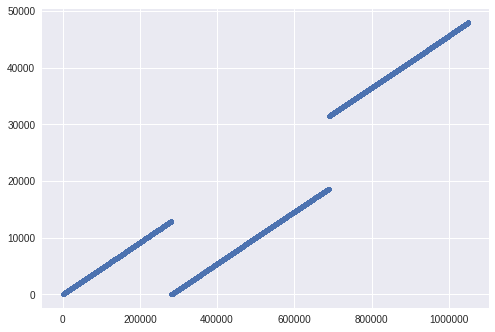

In [24]:
import matplotlib.pyplot as plt
plt.plot(df_ner['sentence_idx'].values,'.');


Hay un porcentaje del inicio que se repite posteriormente, posiblemente con pequeñas variaciónes, esta elección por parte de los creadores del dataset no esta documentada.
A continuación solucionaremos este inconveniente.

In [25]:
df_ner_1=df_ner.iloc[:281834]
df_ner_2=df_ner.iloc[281835:]
dataX_1 = df_ner_1.groupby('sentence_idx')["lemma"].apply(np.array).values
dataPOS_1 = df_ner_1.groupby('sentence_idx')["pos"].apply(np.array).values #posible uso futuro
dataY_1 = df_ner_1.groupby('sentence_idx')["tag"].apply(np.array).values
print('cantidad de sentencias=',len(dataY),'\n')

print(dataX_1[0])
print('dataX.shape=',dataX_1.shape,'\n')

print(dataY_1[0])
print('dataY.shape=',dataY_1.shape)

cantidad de sentencias= 35177 

['thousand' 'of' 'demonstr' 'have' 'march' 'through' 'london' 'to'
 'protest' 'the' 'war' 'in' 'iraq' 'and' 'demand' 'the' 'withdraw' 'of'
 'british' 'troop' 'from' 'that' 'countri' '.']
dataX.shape= (12905,) 

['O' 'O' 'O' 'O' 'O' 'O' 'B-geo' 'O' 'O' 'O' 'O' 'O' 'B-geo' 'O' 'O' 'O'
 'O' 'O' 'B-gpe' 'O' 'O' 'O' 'O' 'O']
dataY.shape= (12905,)


In [26]:
dataX=np.append(dataX_1,df_ner_2.groupby('sentence_idx')["lemma"].apply(np.array).values)
dataPOS=np.append(dataPOS_1,df_ner_2.groupby('sentence_idx')["pos"].apply(np.array).values) #posible uso futuro
dataY=np.append(dataY_1,df_ner_2.groupby('sentence_idx')["tag"].apply(np.array).values)

print(dataX[12905])
print('dataX.shape=',dataX.shape,'\n')

print(dataY[12905])
print('dataY.shape=',dataY.shape)

['thousand' 'of' 'demonstr' 'have' 'march' 'through' 'london' 'to'
 'protest' 'the' 'war' 'in' 'iraq' 'and' 'demand' 'the' 'withdraw' 'of'
 'british' 'troop' 'from' 'that' 'countri' '.']
dataX.shape= (48082,) 

['O' 'O' 'O' 'O' 'O' 'O' 'B-geo' 'O' 'O' 'O' 'O' 'O' 'B-geo' 'O' 'O' 'O'
 'O' 'O' 'B-gpe' 'O' 'O' 'O' 'O' 'O']
dataY.shape= (48082,)


## (b) Distribución de largos y palabras.
> Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. **¿Se observa una ley Zipf?**[[1]](#refs) Realice un gráfico de la cantidad de datos por clase. Comente.



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


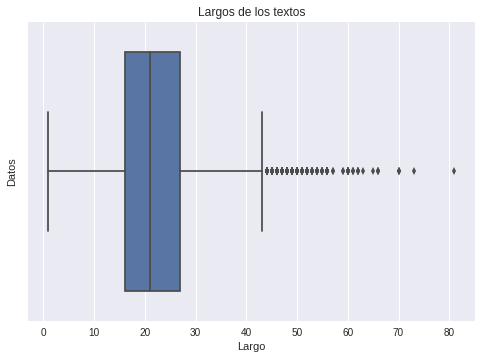

In [27]:
import seaborn as sns
#observar distribución del largo de los textos
sns.boxplot([len(text) for text in dataX]);
plt.title('Largos de los textos')
plt.ylabel('Datos')
plt.xlabel('Largo')
plt.show()

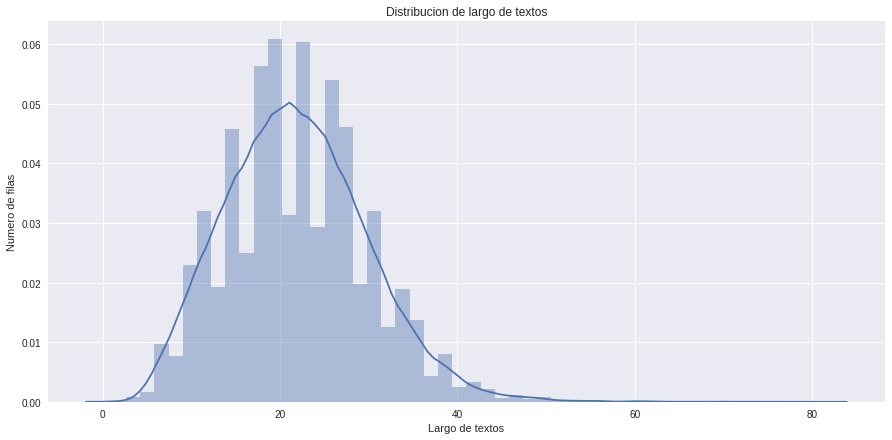

In [28]:
phrases_len = []
for row in dataX:
    phrases_len.append(len(row))

plt.figure(figsize=(15,7))
sns.distplot(phrases_len)
plt.xlabel("Largo de textos")
plt.ylabel("Numero de filas")
plt.title("Distribucion de largo de textos");

Podemos observar que la distribución de los largos no es simetrica, con varios outliers hacia la derecha. La mayoria de las oraciones son cortas, encontrandose la mayoria entre los 10 y los 35. Tambien podemos notar que la distribución es muy cercana a una normal.

In [0]:
from collections import Counter

counts = Counter(np.concatenate(dataX))
(keys,values) = zip(*counts.items())
#plt.bar(values,keys);

In [30]:
print('cantidad de lemmas =',len(keys))

cantidad de lemmas = 20243


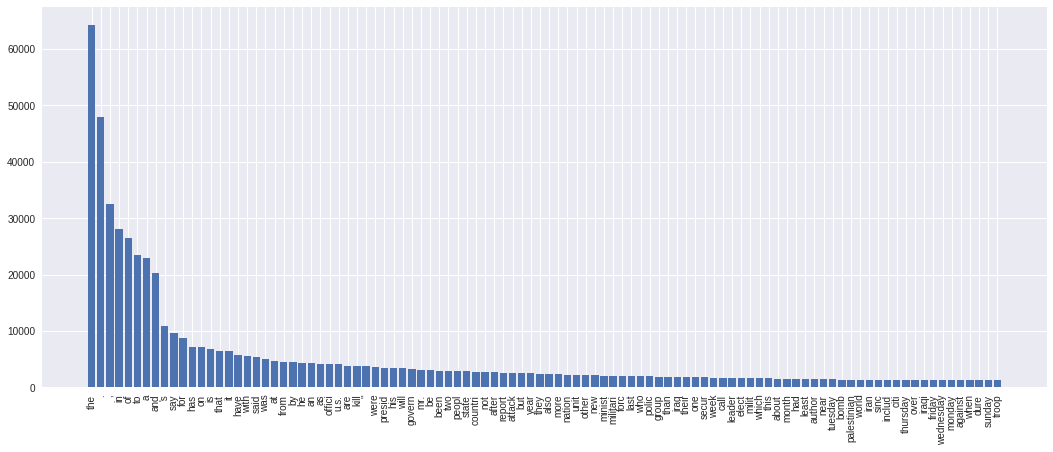

In [31]:
largo=100
delta=0

indSort = np.argsort(values)[::-1]
keys_new = np.array(keys)[indSort]
values_new = np.array(values)[indSort]

plt.figure(figsize=(18,7))
plt.bar(range(largo), values_new[delta:largo+delta])
# Rotation of the bars names
plt.xticks(range(largo), keys_new[delta:largo+delta], rotation=90);

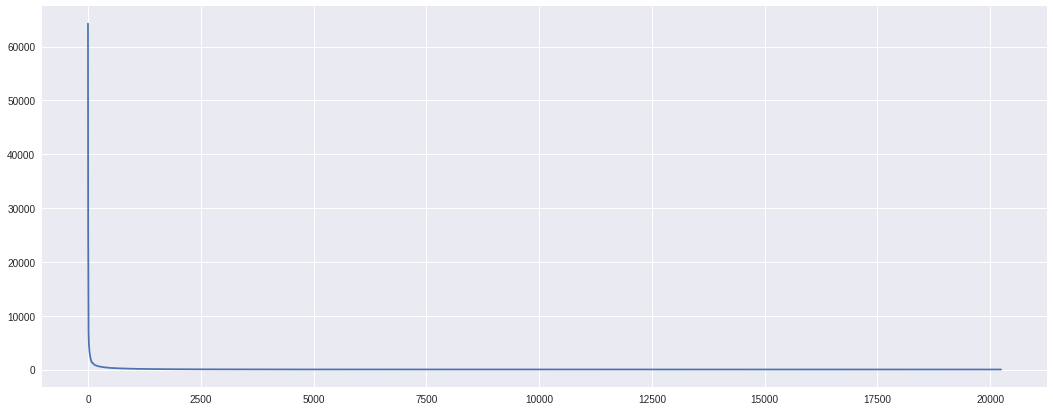

In [32]:
largo=20243
delta=0

indSort = np.argsort(values)[::-1]
keys_new = np.array(keys)[indSort]
values_new = np.array(values)[indSort]

plt.figure(figsize=(18,7))
plt.plot(range(largo), values_new[delta:largo+delta]);

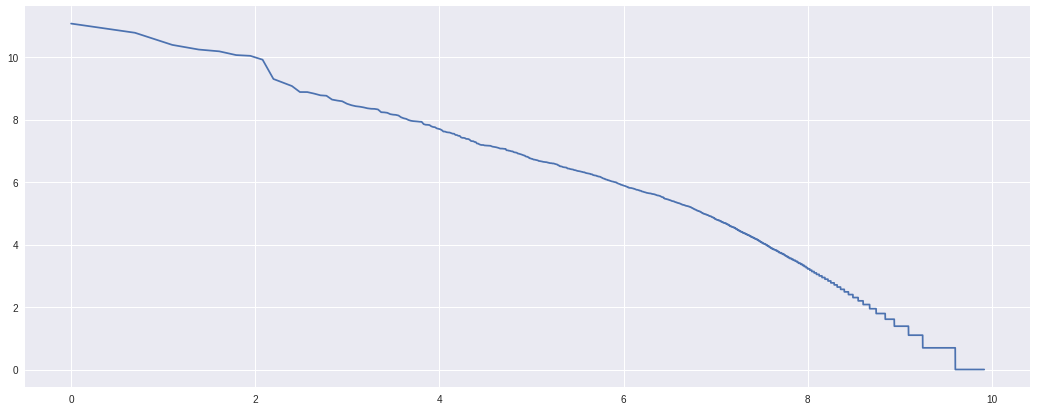

In [33]:
plt.figure(figsize=(18,7))
plt.plot(np.log(range(1,largo+1)), np.log(values_new[delta:largo+delta]));

Mean squared error: 0.0608018523


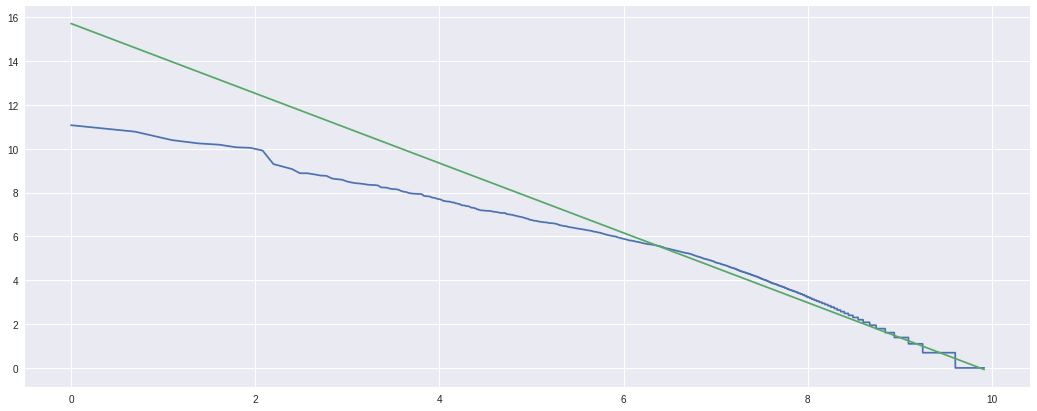

In [34]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(np.log(range(1,largo+1)).reshape(-1, 1), np.log(values_new[delta:largo+delta]).reshape(-1, 1))

# Make predictions using the testing set
y_pred = regr.predict(np.log(range(1,largo+1)).reshape(-1, 1))


print("Mean squared error: %.10f"
      % mean_squared_error(np.log(values_new[delta:largo+delta]).reshape(-1, 1), y_pred))

plt.figure(figsize=(18,7))
plt.plot(np.log(range(1,largo+1)), np.log(values_new[delta:largo+delta]));
plt.plot(np.log(range(1,largo+1)), y_pred);

Es una ley empírica formaulada por George Kingsley Zipf (de ahí su nombre), la cual formula que para cualquier lengua la frecuencia de aparición de distintas palabras sigue una distribución de la forma:

$$P_n \sim \frac{C}{n^a}$$
Si aplicamos el logaritmo a la ecuación anterior podemos obtener la siguiente relación lineal:

$$Log(P_n)=Log(C)-a Log(n)$$
$$Y=b+m\cdot X$$
Con lo que es posible hacer una regresión lineal.

Podemos observar que esta es una buena aproximación por el error cuadratico medio obtenido al hacer la regressión señalada, por lo que efectivamente se cumple la ley de Zipf.

Ref: https://es.wikipedia.org/wiki/Ley_de_Zipf

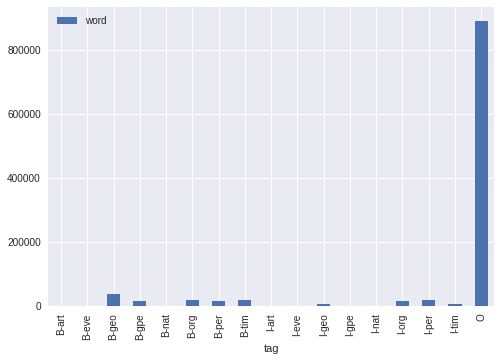

In [73]:
#Ver la distribución de los iob-tag.
df_ner[['tag','word']].groupby('tag').count().plot(kind='bar');

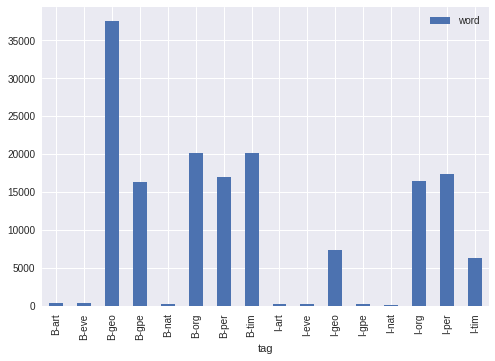

In [74]:
#Ver la distribución de los iob-tag sin O.
df_ner[df_ner.tag!='O'][['tag','word']].groupby('tag').count().plot(kind='bar');

Podemos observar que hay un desvalanceo importante en las clases, especialmente de la clase O, lo que podria ser un porblema y se debe tomar en cuenta, para obtener un buen desempeño en los modelos que se propondran más adelante.

##(c) Construcción entrada y salida.
>Es necesario transformar los textos para que puedan ser entregados apropiadamente a la red, por lo que será necesario crear una función que codifique cada posible *lemma* a un número y cada posible *tag* a otro número, utilice esta función sobre las sentencias y *tags* ya generados. **Mida cual es el largo máximo de entre todas las sentencias, la cantidad de *lemmas* y etiquetas**. Además de esto, debido al largo distinto de las sentencias se deberá **realizar *padding* para estandarizar el largo**, considere algun carácter especial para codificar el espacio en blanco que luego se le deberá rellenar, por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un *lemma* que codificado significará el fin de la sentencia "the rocket *ENDPAD ENDPAD*" que codificado quedará como [32,4,*0, 0*].
```python
...#add fullfill lemma and tag to the dictionary
lemma2idx = {w: i for i, w in enumerate(lemmas)} #Converting text to numbers
lab2idx = {t: i for i, t in enumerate(labels)}
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX]
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY]
n_lemmas = len(lemmas)
n_labels = len(labels)
```



In [35]:
print('largo maximo =',max([len(text) for text in dataX]))

counts = Counter(np.concatenate(dataX))
(lemmas,values) = zip(*counts.items())
indSort = np.argsort(values)
lemmas = np.array(lemmas)[indSort]

lemma2idx = {w: i+1 for i, w in enumerate(lemmas)} #Converting text to numbers


counts = Counter(np.concatenate(dataY))
(labels,values) = zip(*counts.items())
indSort = np.argsort(values)
labels = np.array(labels)[indSort]

lab2idx = {t: i+1 for i, t in enumerate(labels)}
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX]
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY]
n_lemmas = len(lemmas)+1#se agrega 1 por el padding
n_labels = len(labels)+1#se agrega 1 por el padding

print('cantidad de lemmas =',n_lemmas)
print('cantidad de labels =',n_labels)


largo maximo = 81
cantidad de lemmas = 20244
cantidad de labels = 18


No es necesario asociar un tag para el padding, si directamente se entrega el valor numerico con el cual se quiere realizar el padding.

Es razonable asociar la menor cantidad de información a las palabras más frecuentes, por lo que utilizar 0 padding y luego asignar las palabras de manera de que las menores sean las de mayor frecuencia (en consecuencia de menor información) tiene sentido.

## (d) Padding
>Realice el *padding* anteriormente mencionado, decida sobre qué le parece más conveniente al rellenar con un valor especial respecto al cómo funciona una red recurrente y cómo funciona su memoria **¿Al principio o al final de la sentencia?** Comente
```python
from keras.preprocessing import sequence
X = sequence.pad_sequences(dataX,maxlen=max_input_lenght,padding='post' or 'pre',value=lemma2idx["yourspecialcharacter"]) 
y = sequence.pad_sequences(dataY,maxlen=max_input_lenght,padding='post' or 'pre',value=lab2idx["endtagger"])
```




Rellenar con ceros el final de nuestra secuencia probocaria que secuencias de largo inferior desechen sus predicciones al procesar ese ultimo tramo de la secuencia, por lo que es más conveniente utilizar pre-padding

In [0]:
from keras.preprocessing import sequence
max_input_lenght=40;
X = sequence.pad_sequences(dataX,maxlen=max_input_lenght,padding='pre',value=0) 
y = sequence.pad_sequences(dataY,maxlen=max_input_lenght,padding='pre',value=0)

##(e) Salida como one hot vectors y test split
>Para el poder entregar una clasificación sobre los distintos *tags* es necesario tranformarlos a *one hot vectors*, debido a que están codificados en números enteros, esto resultará en un arreglo tridimensional con la cantidad de ejemplos, la cantidad máxima de palabras y la cantidad de posibles *tags*. Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación **¿Cuáles son las dimensiones de entrada y salida de cada conjunto?** Comente
```python
from keras.utils import to_categorical
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)
```




La dimensión de la entrada vendra dada unicamente por el largo de la secuencia elegida, en nuestro caso definido por $max\_input\_lenght$ que elegimos $40$ ya que asi se contiene a la mayor parte de los largos, como vimos en la distribución de estos anteriormente. Luego la dimensión de entrada viene dada por:
$$dim_{in}=max\_input\_lengh \times 1$$

Similarmente la dimensión de la salida viene dada por el largo de la secuencia de salida, para este caso el mismo valor que  $max\_input\_lenght$ y por la cantidad de labels (incluido el label de padding), luego la dimensión de salida vendra dada por $$dim_{out}=max\_input\_lenght \times n\_labels+1=40 \times 18$$



In [0]:
from keras.utils import to_categorical
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)

##(f) LSTM
> Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto, entrene y evalúe su desempeño sobre ambos conjuntos. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red no es un vector como anteriormente se ha trabajado, sino que tiene una dimensión extra la cual es debido a que en cada instante de tiempo se necesita entregar un *output*. Como los *lemmas* corresponden a datos esencialmente categóricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformación entrenable desde el espacio de representación original (discreto) a ${\rm I\!R}^{d}$ , con $d$ la dimensionalidad del *embedding*. **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**.
```python
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
```
Para evaluar su modelo utilice una métrica adecauda para el desbalance presente entre las clases como identificó en el punto b).
```python
from sklearn.metrics import f1_score
print("F1 score on test: ", f1_score(y_test, model.predict(X_test,verbose=0))
```



In [0]:
epochs=25;
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 32)            647808    
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 100)           53200     
_________________________________________________________________
dense_1 (Dense)              (None, 40, 18)            1818      
Total params: 702,826
Trainable params: 702,826
Non-trainable params: 0
_________________________________________________________________
Train on 33657 samples, validate on 14425 samples
Epoch 1/25
33657/33657 [==============================] - 37s 1ms/step - loss: 0.7176 - val_loss: 0.3701
Epoch 2/25
33657/33657 [==============================] - 35s 1ms/step - loss: 0.2504 - val_loss: 0.1827
Epoch 3/25
33657/33657 [==============================] - 35s 1ms/step - loss: 0.1469 - val_loss: 0.1269
Epoch 4/25
33657/33657 [===========

* Parametros Capa LSTM de $n$ nodos y entrada de tamaño $m$: 
$$\#Params=4\cdot(n^2+nm+n)$$

In [0]:
from sklearn.metrics import f1_score

print_f1_score();

F1 score on test:  0.9570303459493796


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


* Problemas calculo f1:

>Al intentar obtener el score f1 con el codigo provisto se encontro con que el formato de la salida y en consecuencia la predicción de esta no eran compatibles con la función score_f1 de scikit-learn. Para solucionar esta problematica se debio representar la salida segun la definición de 'multiclass' dada por scikit-learn ([reft](https://scikit-learn.org/stable/modules/generated/sklearn.utils.multiclass.type_of_target.html)), para lograr esto basto con convertir cada salida de la secuencia nuevamente a su representación unidimensional y luego concatenar todas las secuencias.

* ¿Tomar en cuenta padding en calculo f1 score?



>No nos interesa esa predicción, por lo que tiene sentido no tomarla en cuenta al momento de calcular el desempeño. Para secuencias cortas no nos daria tanta información el indicador puesto que podria detectar correctamente el padding.

* Uso de average = 'Weigthed'

>Finalmente se eligio para el calculo de f1 score la opcion de average='weigthed', ya que permite tomar encuenta de mejor manera los errores en este caso porque como vimos, el dataset presenta grandes diferencias en la cantidad de entradas por cada clase.

* Desempeño de la red segun f1 score:

>Lo que refleja el valor de f1 score es que el modelo predice de una muy buena manera, esto tomando en cuenta el desvalance de las clases, como se comentaba.

##(g) Efecto variar dimension embedding
>Varı́e la dimensionalidad del embedding inicial y determine si **aumenta o disminuye el error de clasificación**. Comente.

In [0]:
scores=[]
parameters=[]
embedding_vector_list=[64, 128,256,512,1024,2048]
for embedding_vector in embedding_vector_list:
  print('embedding_vector=',embedding_vector)
  model = Sequential()
  model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
  model.add(LSTM(units=100,return_sequences=True))
  model.add(Dense(n_labels, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  model.summary()
  model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=128,verbose=0)
  scores.append(print_f1_score())
  parameters.append(model.count_params())

embedding_vector= 64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 64)            1295616   
_________________________________________________________________
lstm_2 (LSTM)                (None, 40, 100)           66000     
_________________________________________________________________
dense_2 (Dense)              (None, 40, 18)            1818      
Total params: 1,363,434
Trainable params: 1,363,434
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F1 score on test:  0.9583622585830556
embedding_vector= 128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 128)           2591232   
_________________________________________________________________
lstm_3 (LSTM)                (None, 40, 100)           91600     
_________________________________________________________________
dense_3 (Dense)              (None, 40, 18)            1818      
Total params: 2,684,650
Trainable params: 2,684,650
Non-trainable params: 0
_________________________________________________________________
F1 score on test:  0.9605882948198087
embedding_vector= 256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 40, 256)           5182464   
_________________________________________________________________
lstm_4 (LSTM

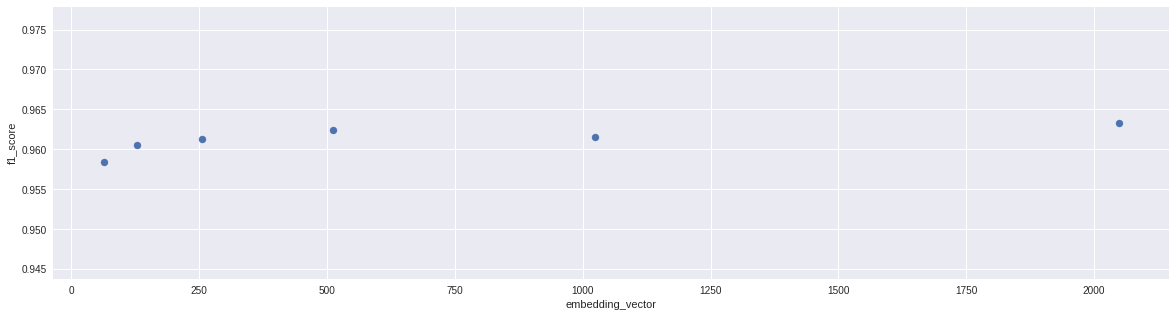

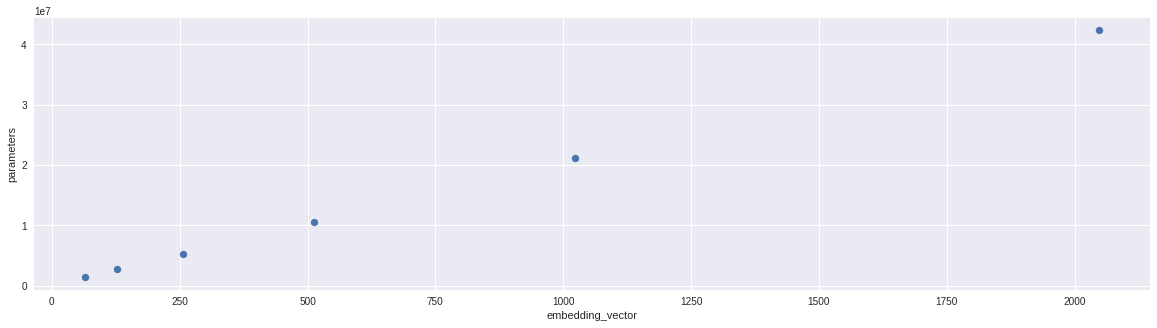

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.scatter(embedding_vector_list,scores,s=50);
plt.ylabel('f1_score');
plt.xlabel('embedding_vector');

plt.figure(figsize=(20,5))
plt.scatter(embedding_vector_list,parameters,s=50);
plt.ylabel('parameters');
plt.xlabel('embedding_vector');

Podemos observar que el rendimiento aumenta hasta un tamaño de 512  de embedding vector, poseteriormente los aumentos en rendimiento son marginales pero la cantidad de parametros va creciendo exponencialmente, en conscuencia los requerimientos de hardware y el tiempo de entrenemiento tambien aumentan considerablemente, de hecho para el caso de tamaño de embedding vector igual a 2048 se llega al limite de memoria de GPU dispuesto en google colab, que es de 12GB.

##(h) Dropout & Dropout recurrente
>Use *Dropout* para entrenar la LSTM. **¿El *Dropout* mejora el desempeño de la red?** Señale cuáles podrı́an ser las causas del comportamiento observado.
```python
from keras.layers import Dropout
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
model.add(LSTM(units=100,return_sequences=True)) #or recurrent_dropout=0.2
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
```

In [0]:
scores=[]
embedding_vector=32;
#solo dropout normal
from keras.layers import Dropout
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
model.add(LSTM(units=100,return_sequences=True,recurrent_dropout=0.2)) #or recurrent_dropout=0.2
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=128)
scores.append(print_f1_score())

Train on 33657 samples, validate on 14425 samples
Epoch 1/25
33657/33657 [==============================] - 39s 1ms/step - loss: 0.7084 - val_loss: 0.2911
Epoch 2/25
33657/33657 [==============================] - 37s 1ms/step - loss: 0.2216 - val_loss: 0.1701
Epoch 3/25
33657/33657 [==============================] - 37s 1ms/step - loss: 0.1466 - val_loss: 0.1203
Epoch 4/25
33657/33657 [==============================] - 37s 1ms/step - loss: 0.1092 - val_loss: 0.0993
Epoch 5/25
33657/33657 [==============================] - 38s 1ms/step - loss: 0.0920 - val_loss: 0.0915
Epoch 6/25
33657/33657 [==============================] - 38s 1ms/step - loss: 0.0831 - val_loss: 0.0851
Epoch 7/25
33657/33657 [==============================] - 38s 1ms/step - loss: 0.0770 - val_loss: 0.0825
Epoch 8/25
33657/33657 [==============================] - 38s 1ms/step - loss: 0.0728 - val_loss: 0.0803
Epoch 9/25
33657/33657 [==============================] - 38s 1ms/step - loss: 0.0692 - val_loss: 0.0789
Epoch

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
#solo recurrent dropout
from keras.layers import Dropout
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
model.add(LSTM(units=100,return_sequences=True,recurrent_dropout=0.2))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=128)
scores.append(print_f1_score())

Train on 33657 samples, validate on 14425 samples
Epoch 1/25
33657/33657 [==============================] - 39s 1ms/step - loss: 0.7001 - val_loss: 0.3199
Epoch 2/25
33657/33657 [==============================] - 37s 1ms/step - loss: 0.2283 - val_loss: 0.1762
Epoch 3/25
33657/33657 [==============================] - 38s 1ms/step - loss: 0.1473 - val_loss: 0.1263
Epoch 4/25
33657/33657 [==============================] - 38s 1ms/step - loss: 0.1078 - val_loss: 0.1006
Epoch 5/25
33657/33657 [==============================] - 38s 1ms/step - loss: 0.0880 - val_loss: 0.0902
Epoch 6/25
33657/33657 [==============================] - 38s 1ms/step - loss: 0.0787 - val_loss: 0.0869
Epoch 7/25
33657/33657 [==============================] - 38s 1ms/step - loss: 0.0732 - val_loss: 0.0833
Epoch 8/25
33657/33657 [==============================] - 37s 1ms/step - loss: 0.0691 - val_loss: 0.0816
Epoch 9/25
33657/33657 [==============================] - 38s 1ms/step - loss: 0.0657 - val_loss: 0.0803
Epoch

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
#recurrent dropout y dropout normal
from keras.layers import Dropout
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
model.add(LSTM(units=100,return_sequences=True,recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=128)
scores.append(print_f1_score())

Train on 33657 samples, validate on 14425 samples
Epoch 1/25
33657/33657 [==============================] - 40s 1ms/step - loss: 0.7306 - val_loss: 0.3836
Epoch 2/25
33657/33657 [==============================] - 38s 1ms/step - loss: 0.2644 - val_loss: 0.1772
Epoch 3/25
33657/33657 [==============================] - 37s 1ms/step - loss: 0.1492 - val_loss: 0.1191
Epoch 4/25
33657/33657 [==============================] - 37s 1ms/step - loss: 0.1077 - val_loss: 0.0990
Epoch 5/25
33657/33657 [==============================] - 38s 1ms/step - loss: 0.0911 - val_loss: 0.0902
Epoch 6/25
33657/33657 [==============================] - 38s 1ms/step - loss: 0.0833 - val_loss: 0.0863
Epoch 7/25
33657/33657 [==============================] - 37s 1ms/step - loss: 0.0780 - val_loss: 0.0842
Epoch 8/25
33657/33657 [==============================] - 38s 1ms/step - loss: 0.0738 - val_loss: 0.0824
Epoch 9/25
33657/33657 [==============================] - 37s 1ms/step - loss: 0.0710 - val_loss: 0.0819
Epoch

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


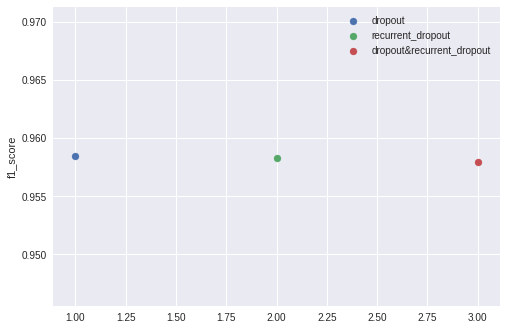

In [0]:
labels=['dropout','recurrent_dropout','dropout&recurrent_dropout']
for i in range(3):
  plt.scatter(i+1,scores[i],label=labels[i]);
plt.ylabel('f1_score')
plt.legend();

Podemos observar que se converge a un rendimiento similar con todas las combinaciones de dropout y tambien sin este, siendo el uso de recurrent dropout marginalmente mejor al resto. 


##(i) Bi-LTSM
>Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen.**Mejore la red definida en f) utilizando una red neuronal recurrente Bidireccional**, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas* de entrada. Comente **cuál debiera ser la forma correcta de usar el parámetro *merge_mode*** (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. **¿Mejora o empeora el desempeño?** Analice.
```python
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode=choose))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
```


In [40]:
from keras.layers import Bidirectional

embedding_vector=32
opt_merge_mode=['sum', 'mul', 'concat', 'ave'];
scores=[]
for i in opt_merge_mode:
  print('merge_mode=',i)
  model = Sequential()
  model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
  layer_lstm = LSTM(units=100,return_sequences=True)
  model.add(Bidirectional(layer_lstm,merge_mode=i))
  model.add(Dense(n_labels, activation='softmax'))
  model.summary()
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=128)
  scores.append(print_f1_score())

merge_mode= sum
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 32)            647808    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 40, 100)           106400    
_________________________________________________________________
dense_5 (Dense)              (None, 40, 18)            1818      
Total params: 756,026
Trainable params: 756,026
Non-trainable params: 0
_________________________________________________________________
Train on 33657 samples, validate on 14425 samples
Epoch 1/25
33657/33657 [==============================] - 66s 2ms/step - loss: 0.5916 - val_loss: 0.3136
Epoch 2/25
33657/33657 [==============================] - 64s 2ms/step - loss: 0.2193 - val_loss: 0.1554
Epoch 3/25
33657/33657 [==============================] - 63s 2ms/step - loss: 0.1167 - val_loss: 0.0980
Epoch 4/25
33657/33

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F1 score on test:  0.9652165202750126
merge_mode= mul
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 32)            647808    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 40, 100)           106400    
_________________________________________________________________
dense_6 (Dense)              (None, 40, 18)            1818      
Total params: 756,026
Trainable params: 756,026
Non-trainable params: 0
_________________________________________________________________
Train on 33657 samples, validate on 14425 samples
Epoch 1/25
33657/33657 [==============================] - 67s 2ms/step - loss: 0.8282 - val_loss: 0.3094
Epoch 2/25
33657/33657 [==============================] - 64s 2ms/step - loss: 0.2186 - val_loss: 0.1660
Epoch 3/25
33657/33657 [==============================] - 63s 2ms/step - loss: 0.1312 

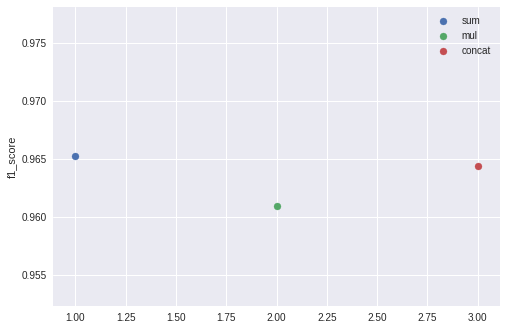

In [41]:
for i in range(3):
  plt.scatter(i+1,scores[i],label=opt_merge_mode[i]);
plt.ylabel('f1_score')
plt.legend();


La version Bi direccional de las LSTM hace además de la pasada tradicional, de intentar estimar una salida dada las entradas del pasado, agrega además una pasada en el sentido contrario, es decir, toma información del futuro para estimar una salida. Estos dos resultados se juntan dependiendo del metodo de merge mode elegido.

*   ¿Cual debiera sel el merge_mode?

>A priori no se ve una razon evidente para usara uno por sobre otro. Podemos observando los desempeños logrados, la opción de merge mode "sum" (suma) fue la con mejor f1 score, sin embargo el resto tambien esta en un rango muy cercano de rendimiento, siendo muy poca la diferencia por la que el merge mode señalado supera a las otras dos opciones evaluadas.

*  Conclusion desempeño.

>Efectivamente el desempeño mejora, marginalmente, pero de todas maneras es superior a lo que se obtuvo con LSTM unidireccional (0.9583787580691812).



##(j) Masking
>Recientemente se ha implementado la capa de *Masking* en las redes recurrentes en *keras*, lo cual podría traer gran ayuda gracias al *padding* que se realiza con el símbolo especial definido. **Entrene la red definida en f) y compare al utilizar esta funcionalidad de enmascarar el valor 0 en este caso para el *default* de la capa *embedding***, comente sobre las curvas de entrenamiento y los tiempos de entrenamiento.
```python
lemma2idx["yourspecialcharacter"] = 0 #should be zero.. if not correct it
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght,mask_zero=True))
...
```

In [43]:
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght,mask_zero=True))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=128)
print_f1_score();

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 40, 32)            647808    
_________________________________________________________________
lstm_10 (LSTM)               (None, 40, 100)           53200     
_________________________________________________________________
dense_10 (Dense)             (None, 40, 18)            1818      
Total params: 702,826
Trainable params: 702,826
Non-trainable params: 0
_________________________________________________________________
Train on 33657 samples, validate on 14425 samples
Epoch 1/25
33657/33657 [==============================] - 48s 1ms/step - loss: 0.8549 - val_loss: 0.4471
Epoch 2/25
33657/33657 [==============================] - 44s 1ms/step - loss: 0.3810 - val_loss: 0.3389
Epoch 3/25
33657/33657 [==============================] - 44s 1ms/step - loss: 0.2856 - val_loss: 0.2468
Epoch 4/25
33657/33657 [===========

El uso de una mascara permite que se ajuste el largo de la secuencia para las que sean de largo menor, esto es al menos intuitivamente beneficicioso ya que no es necesario que la red aprenda a hacer el mapeo a los valores de padding. A pesar de esto, podemos observar que el desempeño es practicamente el mismo, y de hecho un poco menor. (0.9583787580691812)

##(k) Mejoras Propuestas
>En base a lo experimentado, **intente mejorar el desempeño de las redes encontradas**, ya sea utilizando y combinando las distintas variaciones que se hicieron en los distintos ítemes, como bien alguna mejora en el pre-proceso de los datos (largo de secuencia, el tipo de *padding* o alguna otra), agregar mayor profundidad, variar el número de unidades/neuronas, utilizando otra *gate* de recurrencia (GRU o Vanilla/Simple), en https://keras.io/layers/recurrent/,  entre otras.



In [44]:
embedding_vector = 512
epochs=10
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
model.add(Bidirectional(LSTM(units=100,return_sequences=True),merge_mode='sum'))
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=128)
print_f1_score();

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 40, 512)           10364928  
_________________________________________________________________
bidirectional_9 (Bidirection (None, 40, 100)           490400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 100)           0         
_________________________________________________________________
dense_11 (Dense)             (None, 40, 18)            1818      
Total params: 10,857,146
Trainable params: 10,857,146
Non-trainable params: 0
_________________________________________________________________
Train on 33657 samples, validate on 14425 samples
Epoch 1/10
33657/33657 [==============================] - 71s 2ms/step - loss: 0.3196 - val_loss: 0.1000
Epoch 2/10
33657/33657 [==============================] - 67s 2ms/step - loss: 0.0802 - val_loss: 0.0727
Ep

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Se eligio mezclar las variaciones que nos dieron mejores resultados, estas son el uso de LSTM bidireccionales con merge_mode = 'sum', dropout normal y un gran tamaño para el embedding vector. Podemos observar que se obtuvo un f1 score superior a los modelos anteriormente generados.

##(l) Predicciones Modelo Propuesto
>Utilice la red entranda anteriormente, **se espera que sea la mejor de esta sección**, y **muestre las predicciones**, el *NER tager*, sobre algún ejemplo de pruebas, comente.  
```python
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15}: {}".format("Lemma", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:15}: {}".format(lemmas[w],labels[pred]))
```


In [45]:
i=35;
idx2lemma = {v: k for k, v in lemma2idx.items()}
idx2lemma[0]=0;
idx2lab = {v: k for k, v in lab2idx.items()}
idx2lab[0]=0
p = model.predict_classes(np.array([X_test[i]]))
print("{:15}: {:15}:{}".format("Lemma", "Pred","true"))
for w,pred,true in zip(X_test[i],p[0],np.argmax(y_test[i],axis=-1)):
    print("{:15}: {:15}: {}".format(idx2lemma[w],idx2lab[pred],idx2lab[true]))

Lemma          : Pred           :true
              0:               0: 0
              0:               0: 0
              0:               0: 0
              0:               0: 0
              0:               0: 0
              0:               0: 0
              0:               0: 0
              0:               0: 0
              0:               0: 0
              0:               0: 0
              0:               0: 0
              0:               0: 0
earlier        : O              : O
,              : O              : O
gate           : B-per          : B-per
met            : O              : O
prime          : B-per          : B-per
minist         : O              : O
phan           : B-per          : B-per
van            : I-per          : I-per
khai           : I-per          : I-per
and            : O              : O
presid         : B-per          : B-per
tran           : I-per          : I-per
duc            : I-per          : I-per
luong          : I-per        

* Comentarios respecto a desempeño.

Anteriormente pudimos ver que el f1 score era muy elevado, ahora contrastamos con las predicciones realizadas para un ejemplo y efectivamente podemos observar que para el ejemplo selecciónado se tiene una perfecta predicción, esto no sucede para todos los casos, pero en general el desempeño de la predicción es bastante bueno.

##(m) Predictor de Texto

>Ahora utilizaremos el mismo dataset para realizar una aplicación más conocida hoy en día que es el autocompletar texto, esto es, predecir la siguiente palabra de una sentencia basada en las palabras anteriores de la misma, por lo que la red que utilizaremos es del tipo *many to one*.  
Debido a lo extenso del vocabulario es bastante complejo hacer un modelo que prediga una palabra dentro de las millones que pueden haber, por lo que, **trabajaremos a nivel de carácter, en donde las posibilidades (posibles clases) son mucho menores**.

>**Carge las palabras del dataset** ¿Por qué no los *lemmas*? y cree el corpus con el cual se trabajará, además de crear la codificación de caracteres a números. Esto se presenta en el código a continuación además de crear la estrucutura de los datos con los que se va a trabajar (sub sentencias del corpus original). **Utilice el tamaño del *corpus* que le acomode a la memoria de su computador**.
```python
dataset = df_ner.loc[:,["word","lemma"]]
text = ' '.join(dataset["word"]).lower() #corpus
null_character = "*"
chars = [null_character]+sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}
maxlen = 40 # cut the text in semi-redundant sequences of maxlen characters
step = 5 
sentences = []
next_chars = []
size = int(len(text)*0.2) #solo un 20% del corpus
for i in range(0, size - maxlen, step):
    sentences.append(null_character+text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))
```

In [46]:
dataset = df_ner.loc[:,["word","lemma"]]
text = ' '.join(dataset["word"]).lower() #corpus
null_character = "*"
chars = [null_character]+sorted(list(set(text))) #Caracteres menos a más relevantes (menos a más información)
print('total chars:', len(chars))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}
maxlen = 40 # cut the text in semi-redundant sequences of maxlen characters
step = 5 
sentences = []
next_chars = []
size = int(len(text)*0.2) #solo un 20% del corpus
for i in range(0, size - maxlen, step):
    sentences.append(null_character+text[i: i + maxlen])#Se agrega null caracter para desfazar
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

total chars: 72
nb sequences: 242693


En este caso si tiene sentido utilizar las palabras completas, puesto que la información que se descarta al realizar la lemmatización en general puede dar información del tipo de palabra que la precede.










##(n) Padding Caracteres
>**Procese las sentencias para así tenerlas codificadas en números que van a representar los carácteres**, tal cual se realizó en c) con los *lemmas*, **lo mismo para las etiquetas**. Además de esto deberá realizar el *padding* correspondiente al comienzo de la sentencia, esto es para que la red aprenda cuando venga una frase mas corta de lo entrenado, este símbolo siignificará que no hay información. **Transforme las etiquetas a *one hot vector*** como se realizó en c) y **defina la red** similar a la presentada en f), con un *embedding* seguido de una capa recurrente GRU y la capa de clasificación. Aprovechese de la implementación más rápida de GRU respaldada por __[CuDNN](https://developer.nvidia.com/cudnn)__, una librería de CUDA (NVIDIA)[[2]](#refs) para *Deep Neural Network*. 
```python
dataX = [[char_indices[char] for char in sentence ] for sentence in sentences]
dataY = [char_indices[char] for char in next_chars]
...#dataX pad sequence padding='pre'
...#dataY to categorical with num_classes=len(chars)
from keras.layers import CuDNNGRU,GRU
embedding_vector = 16
model = Sequential()
model.add(Embedding(input_dim=len(chars), output_dim=embedding_vector, input_length=maxlen+1))#
model.add(CuDNNGRU(units=512,return_sequences=False)) #or GRU
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
```




In [0]:
dataX = np.array([[char_indices[char] for char in sentence ] for sentence in sentences])
dataY = np.array([char_indices[char] for char in next_chars])
X=dataX
y=  np.asarray([to_categorical(i, num_classes=len(chars)) for i in dataY])
from keras.layers import CuDNNGRU,GRU
embedding_vector = 16
model = Sequential()
model.add(Embedding(input_dim=len(chars), output_dim=embedding_vector, input_length=maxlen+1))#
model.add(CuDNNGRU(units=512,return_sequences=False)) #or GRU
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Debemos notar que no fue necesario hacer padding, ya que los largos de la entrada ya fueron seteados en el ultimo punto. Las GRU son Gated Recurrent units, estas nodos recurrentes, pero que contienen compuertas en su interior, de manera similar a las LSTM.

##(o) Entrenamiento red Predictora de Texto
>Entrene la red con las funciones que se presentan a continuación que mostrarán el cómo va la tarea de autocompletar texto en cada *epoch*, generando una sentencia completa de 400 carácteres *aleatoriamente* a partir de una semilla *random*. Entrene solo durante 25 *epochs*, a los 15 ya debería comenzar a generar palabras y sonar mas coherente **¿Cuál es la técnica para predecir el siguiente carácter?**
```python
def predict_next_char(model, sentence):
    """Predict the next character from the current one"""    
    x_pred = [char_indices[null_character]]+[char_indices[char] for char in sentence]
    x_pred = sequence.pad_sequences([x_pred], maxlen=maxlen+1,padding='pre',value=char_indices[null_character])
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.random.choice(len(chars), p=preds) #take a sample
    return indices_char[next_index]
import random,sys
def on_epoch_end(epoch, logs):
    """Function invoked at end of each epoch. Prints generated text."""
    print('\n----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, size - maxlen - 1)
    sentence = text[start_index: start_index + maxlen]
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_next_char(model, sentence0)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return
from keras.callbacks import LambdaCallback
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(X, y,batch_size=256,epochs=25, callbacks=[print_callback])
```



In [63]:
def predict_next_char(model, sentence):
    """Predict the next character from the current one"""    
    x_pred = [char_indices[null_character]]+[char_indices[char] for char in sentence]
    x_pred = sequence.pad_sequences([x_pred], maxlen=maxlen+1,padding='pre',value=char_indices[null_character])
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.random.choice(len(chars), p=preds) #take a sample
    return indices_char[next_index]
  
import random,sys

def on_epoch_end(epoch, logs):
    """Function invoked at end of each epoch. Prints generated text."""
    print('\n----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, size - maxlen - 1)
    sentence = text[start_index: start_index + maxlen]
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_next_char(model, sentence)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return
  
from keras.callbacks import LambdaCallback
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(X, y,batch_size=256,epochs=25, callbacks=[print_callback])

Epoch 1/25
242693/242693 [==============================] - 50s 208us/step - loss: 2.5249 - acc: 0.2751

----- Generating text after Epoch: 0
----- Generating with seed: "ny planes landing or taking off from the"
ny planes landing or taking off from the colme 'criats gepeirased inaqion imsicrotile gobe coumitatsing haleles anedan 's sowur on thes of of saktrlintar , andrem winer e fonc prive doas moficeatt hinnevs atend whe pinttaye . bathian antundariciged corite , abnial suever cornisy a llimanglo, agfented rayigy thecitheent soand ancing goshar meag apiginger . the contsang hand mu.sione uf restain qomaaledion the mnits agcea. sabesthe tho afEpoch 2/25
242693/242693 [==============================] - 46s 189us/step - loss: 1.9716 - acc: 0.4171

----- Generating text after Epoch: 1
----- Generating with seed: "ter the british government stripped him "
ter the british government stripped him bold in the owhichs to his on dedved to socenday . ta rafing farlaks in modichations hord dere

Mediante la funcio predict_next_char se implementa la elección del siguiente caracter. En esta se realiza una muestra aleatoria de la función de distribución representada por las salidas de la red, de manera que los caracteres con mayor salida tienen mayor posibilidad de salir.
Con esta función se elige un caracter a partir de la predicción hecha con la secuencia inicial más los caracteres elegidos anteriormente, hasta completar el largo de la secuencia deseada.

## (p) Predicciones de texto y comparación con modelo determinista.
>Verifique la calidad de la red entrenada, cargando el modelo si es que lo guardó o directamente, entregando una predicción sobre una semilla inicial que usted entregue. **Observe y comente cualitativamente sobre qué pasa cuando la predicción del siguiente carácter fuese de manera determinista, tomando el máximo valor de entre las predicciones.**
```python
sentence = "it is "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()
```


In [72]:
sentence = "it is"
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush() 

----- Generating with seed: "it is"
it is contay menion in quest . he depre to structive nocking during share namib , takes , carrel workers voo racu 's gama has relat count ripht recoran contrecal created peoplam currest and say measo . rushipring nucle mondalis sil nicers under dad , while regrier elect tacks of throuh produse intigien srivan russion , hits and from from tourde women satures last outsely , coopery depricons . u.s. sett

In [69]:
def predict_next_char_det(model, sentence):
    """Predict the next character from the current one"""    
    x_pred = [char_indices[null_character]]+[char_indices[char] for char in sentence]
    x_pred = sequence.pad_sequences([x_pred], maxlen=maxlen+1,padding='pre',value=char_indices[null_character])
    preds = model.predict_classes(x_pred, verbose=0)
    next_index = preds[0]
    return indices_char[next_index]
  
sentence = "it is "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char_det(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()

----- Generating with seed: "it is "
it is conting charger , the on the north of india crossing and expect day . the victor grouns say threate and that has countries , and expect day . the victor grouns say threate and that has countries , and expect day . the victor grouns say threate and that has countries , and expect day . the victor grouns say threate and that has countries , and expect day . the victor grouns say threate and that has

Si bien las oraciones creadas en general no tienen mucho sentido, el texto en general se asemeja al ingles, con varias palabras en ese idioma y varias palabras similares pero completamente sin significado. Podemos observar adicionalmente que al utilizar el acercamiento determinista surge un loop despues de un periodo y se repite varias veces las mismas frases por lo que si se quiere generar una secuencia muy larga a partir de una semilla, de la manera que se estaba haciendo, es mejor el acercamiento probabilistico.

<a id="refs"></a>
## Referencias
[1] George Kingsley Zipf (1949), *Human behavior and the principle of least effort*, Addison-Wesley Press  
[2] https://www.nvidia.es/object/cuda-parallel-computing-es.html  
[3] http://yann.lecun.com/exdb/mnist/  
[4] Vincent, P., Larochelle, H., Bengio, Y., & Manzagol, P. A. (2008, July). *Extracting and composing robust features with denoising autoencoders*. ACM.